<a href="https://colab.research.google.com/github/gauriagarwal18/NYC-Taxi-Trip-Time-Prediction/blob/master/NYC_Taxi_Trip_Time_Prediction_Capstone_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <b><u> Project Title : Taxi trip time Prediction : Predicting total ride duration of taxi trips in New York City</u></b>

## <b> Problem Description </b>

### Your task is to build a model that predicts the total ride duration of taxi trips in New York City. Your primary dataset is one released by the NYC Taxi and Limousine Commission, which includes pickup time, geo-coordinates, number of passengers, and several other variables.

##Data Loading And Description

###We are using the following libraries for analysis:
- Numpy: We will use numpy arrays as they are comparitively faster than lists, also columns of dataframes behaves as numpy arrays

- Pandas: for reading the data from csv file, for data cleaning and for preparing data for analysis

- matplotlib,seaborn: for different visualisations, for drawing conclusions from data and for exploratory data analysis. 

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

###Data Loading
Loading CSV file from google drive in colab enviroment:
We will first load our csv file in which data is stored to the colab enviroment in data frame format so that we can make the copy of the original data and perform the required cleaning and analysis on that data without changing the original one.



In [ ]:
#Download datasets 
from google.colab import drive
drive.mount('/content/drive')
import os
path="/content/drive/My Drive/AlmaBetter_Capstone_projects/Capstone_project2_ml/NYC_TaxiData.csv"
taxi_original=pd.read_csv(path,parse_dates=[2,3])
taxi= taxi_original.copy()

Mounted at /content/drive


###Data Description

In [ ]:
#shape of the data
taxi.shape

(1458644, 11)

In [ ]:
taxi.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435




The dataset is based on the 2016 NYC Yellow Cab trip record data made available in Big Query on Google Cloud Platform. The data was originally published by the NYC Taxi and Limousine Commission (TLC). The data was sampled and cleaned for the purposes of this project. Based on individual trip attributes, you should predict the duration of each trip in the test set.

<b>NYC Taxi Data.csv</b> - the training set (contains 1458644 trip records)


<b>Data fields</b>
* #### id - a unique identifier for each trip
* #### vendor_id - a code indicating the provider associated with the trip record
* #### pickup_datetime - date and time when the meter was engaged
* #### dropoff_datetime - date and time when the meter was disengaged
* #### passenger_count - the number of passengers in the vehicle (driver entered value)
* #### pickup_longitude - the longitude where the meter was engaged
* #### pickup_latitude - the latitude where the meter was engaged
* #### dropoff_longitude - the longitude where the meter was disengaged
* #### dropoff_latitude - the latitude where the meter was disengaged
* #### store_and_fwd_flag - This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server - Y=store and forward; N=not a store and forward trip
* #### trip_duration - duration of the trip in seconds

In [ ]:
taxi.info()
"""
here we note that there is not any null value in data right now,
we have two date-time columns
"""

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   id                  1458644 non-null  object        
 1   vendor_id           1458644 non-null  int64         
 2   pickup_datetime     1458644 non-null  datetime64[ns]
 3   dropoff_datetime    1458644 non-null  datetime64[ns]
 4   passenger_count     1458644 non-null  int64         
 5   pickup_longitude    1458644 non-null  float64       
 6   pickup_latitude     1458644 non-null  float64       
 7   dropoff_longitude   1458644 non-null  float64       
 8   dropoff_latitude    1458644 non-null  float64       
 9   store_and_fwd_flag  1458644 non-null  object        
 10  trip_duration       1458644 non-null  int64         
dtypes: datetime64[ns](2), float64(4), int64(3), object(2)
memory usage: 122.4+ MB


'\nhere we note that there is not any null value in data right now,\nwe have two date-time columns\n'

In [ ]:
taxi.describe(include="all")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  """Entry point for launching an IPython kernel.


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
count,1458644,1.458644e+06,1458644,1458644,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1458644,1.458644e+06
unique,1458644,NaN,1380222,1380377,NaN,NaN,NaN,NaN,NaN,2,NaN
top,id2875421,NaN,2016-03-04 08:07:34,2016-02-19 19:25:04,NaN,NaN,NaN,NaN,NaN,N,NaN
freq,1,NaN,5,5,NaN,NaN,NaN,NaN,NaN,1450599,NaN
first,NaN,NaN,2016-01-01 00:00:17,2016-01-01 00:03:31,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,NaN,2016-06-30 23:59:39,2016-07-01 23:02:03,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,1.534950e+00,NaN,NaN,1.664530e+00,-7.397349e+01,4.075092e+01,-7.397342e+01,4.075180e+01,NaN,9.594923e+02
std,NaN,4.987772e-01,NaN,NaN,1.314242e+00,7.090186e-02,3.288119e-02,7.064327e-02,3.589056e-02,NaN,5.237432e+03
min,NaN,1.000000e+00,NaN,NaN,0.000000e+00,-1.219333e+02,3.435970e+01,-1.219333e+02,3.218114e+01,NaN,1.000000e+00
25%,NaN,1.000000e+00,NaN,NaN,1.000000e+00,-7.399187e+01,4.073735e+01,-7.399133e+01,4.073588e+01,NaN,3.970000e+02


In [ ]:
taxi.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration'],
      dtype='object')

In [ ]:
categorical=["vendor_id","passenger_count","store_and_fwd_flag"]
continuous=['pickup_longitude', 'pickup_latitude','dropoff_longitude', 'dropoff_latitude','trip_duration']
for c in categorical:
  
  print(f"distribution of {c}:\n{taxi[c].value_counts()}\n\n")

distribution of vendor_id:
2    780302
1    678342
Name: vendor_id, dtype: int64


distribution of passenger_count:
1    1033540
2     210318
5      78088
3      59896
6      48333
4      28404
0         60
7          3
9          1
8          1
Name: passenger_count, dtype: int64


distribution of store_and_fwd_flag:
N    1450599
Y       8045
Name: store_and_fwd_flag, dtype: int64




Here we note that store and fwd flag is highly biased.
There are several records where passenger count is zero, which is of no use, as none of the passenger will require time duration when there is no passenger in the taxi

##Data Cleaning

In [ ]:
def print_null_percent(df):
  null_percent=pd.Series()
  for col in df.columns:
    null_percent[col]=((df.shape[0]-df[col].count())/(df.shape[0]))*100
  print("columns with null values\n",null_percent[null_percent!=0])


In [ ]:
#removing outliers using z-score method
def remove_outliers(df,continuous_col=[]):
  from scipy import stats

  if len(continuous_col)==0:
    continuous_col=df.describe().columns
  df[continuous_col].boxplot(rot=90)
  plt.title("before removing outliers",)
  plt.show()
  
  for c in continuous_col:
    df = df[stats.zscore(df[c])<3] 
    
    #df.loc[upper][c]=Q3
    #df.loc[lower][c]=Q1
     
  df.boxplot(rot=90)
  plt.title("after removing outliers",)
  plt.show()
  return df

In [ ]:
#to remove outliers using quantile method
def remove_outliers2(df,continuous_col=[]):

  if len(continuous_col)==0:

   continuous_col=df.describe().columns
  df.boxplot(rot=90)
  plt.title("before removing outliers",)
  plt.show()
  
  for c in continuous_col:
    df.index=np.arange(0,df.shape[0])
    Q1=np.quantile(df[c],0.25)
    Q3=np.quantile(df[c],0.75)
    IQR= Q3 - Q1
    upper=np.where(df[c]>=(Q3+1.5*IQR))[0]
    #print(upper[0])
    lower=np.where(df[c]<=(Q1-1.5*IQR))[0]   #it will be a tuple and we require a numpy array which is at it's first index.
    #print(lower)
    outliers_idx=np.unique(np.append(upper,lower)) 
    df.drop(outliers_idx, inplace = True) 
    
    #df.loc[upper][c]=Q3
    #df.loc[lower][c]=Q1
     
  df.boxplot(rot=90)
  plt.title("after removing outliers",)
  plt.show()
  return df

In [ ]:
def normalization(df,col_list):

  for c1 in col_list:
    try:
      mx=df.max()[c1]
      mn=df.min()[c1]
      df[c1]=(df[c1]-mn)/(mx-mn)
      col_list.remove(c1)    #so that c1 do  not get normalized again and again
    except:
      print(f"{c1} is not a numerical column, so it can not be normalized")
      col_list.remove(c1)
      normalization(df,col_list)

In [ ]:
"""
presently data do not have any null value but it may be introduced later
"""
def cleaning(df,continuous_col=[],discrete_col=[],print_null=True,th=20.0):
  """
  this function removes all the null values from the data 
  """

  print(f"before cleaning\n")
  print(f"shape of data: {df.shape}")
  if(print_null):
    print_null_percent(df)
  
  #step1
  #preserving columns having at least 20% of not null values
  df.dropna(axis=1,inplace=True,thresh=((th/100.0)*df.shape[0]))
  #preserving rows having at least 20% of not null values
  df.dropna(axis=0,inplace=True,thresh=((th/100.0)*df.shape[1]))

  #step2
  df.drop_duplicates(inplace=True,ignore_index=True)
  

  #step3
  #removing all the null values
  for c1 in df.columns:

    #i.e it is an non catagorical column
    if c1 in continuous_col: 
      df[c1].fillna(df[c1].mean(),inplace=True)
    else:
      df[c1].fillna(df[c1].value_counts().idxmax(),inplace=True)

  print(f"\n\nAfter cleaning the data\n")
  print(f"shape of data: {df.shape}")
  print_null_percent(df)
  return df

In [ ]:
taxi=cleaning(taxi,continuous,categorical,th=20)

before cleaning

shape of data: (1458644, 11)
columns with null values
 Series([], dtype: float64)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  




After cleaning the data

shape of data: (1458644, 11)
columns with null values
 Series([], dtype: float64)


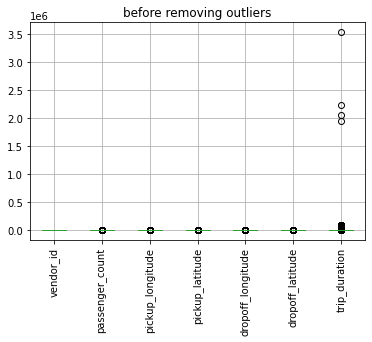

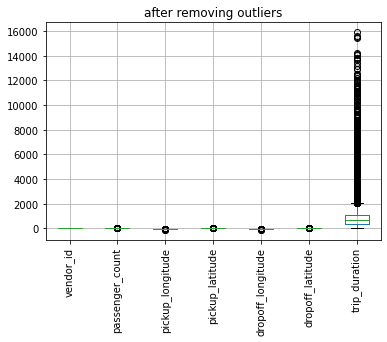

In [ ]:
taxi = remove_outliers(taxi)  #later if we observe any outlier in data than we will also remove it

In [ ]:
taxi.shape  #we have also tried removing outliers from quantile method, but in that case nearly 25% of the total values get removed.

(1397889, 11)

##Feature Engineering


###First let's add the required columns

- In adding columns there is nothing to do with id, vendor_id, passenger_count, dropoff_datetime,store_and_fwd_flag and trip_duration, so these columns are left untouch in this section.
- In **pickup_datetime:** 
  - we first separate date and time and then seperate different sections of date and time, in date, month, year and hour, we do not consider minutes and seconds as they are not that much important for prediction 
  - also we added which day of week it is and them added a column is_weekend which checks whether a column is weekend or not, as it may be possible that more traffic is observed during office days.
  - Then we added a column which shows among four shift which shift of day taxi is booked for, as different shifts may have different trip_duration for same trip.

- Using all the four columns of latitude and longitude we calculate the total_distance between initial and final position



In [ ]:
#columns before feature engineering
taxi.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration'],
      dtype='object')

####feature engineering on pickup_datetime column:

In [ ]:
from datetime import datetime
from datetime import date

In [ ]:
def get_weekdays(dates):
  import calendar
  from datetime import date
  week_days=[]
  for i in dates:
    my_date = i.date()
    week_days.append(calendar.day_name[my_date.weekday()])
  return week_days


In [ ]:
def separate_date(date_time):
  years,months,dates=[],[],[]
  for i in date_time:
    years.append(i.year)
    months.append(i.month)
    dates.append(i.day)
  return years,months,dates
  

In [ ]:
def separate_time(date_time):
  hours,minutes,seconds=[],[],[]
  for i in date_time:
    hours.append(i.hour)
    minutes.append(i.minute)
    seconds.append(i.second)
  return hours,minutes,seconds

In [ ]:
years,months,dates=separate_date(taxi["pickup_datetime"])
taxi["pickup_year"]=years
taxi["pickup_date"]=dates
taxi["pickup_month"]=months

In [ ]:
"""
for time we will only take hours, as they are important but having minutes and seconds is not 
required as we just want an idea of time.
"""
hours,minutes,seconds=separate_time(taxi["pickup_datetime"])
taxi["pickup_hour"]=hours

In [ ]:
taxi["pickup_weekday"]=get_weekdays((list(taxi["pickup_datetime"])))


In [ ]:
taxi["time_difference"]=taxi["dropoff_datetime"]-taxi["pickup_datetime"]
taxi["time_difference"] = [(i).seconds for i in (taxi["time_difference"])]
taxi[taxi["time_difference"]!=taxi["trip_duration"]]
#no such rows where the difference between pickup and dropoff datetime is not equal to total trip duration

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_year,pickup_date,pickup_month,pickup_hour,pickup_weekday,time_difference


In [ ]:
taxi.head(2)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_year,pickup_date,pickup_month,pickup_hour,pickup_weekday,time_difference
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,2016,14,3,17,Monday,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,2016,12,6,0,Sunday,663


In [ ]:
def convert_weekday(x):
  if x in ['Monday','Tuesday','Wednesday','Thursday','Friday']:
    x = 0
    return x
  else:
    x = 1
    return x

In [ ]:
taxi['is_weekend'] = taxi['pickup_weekday'].apply(convert_weekday)

In [ ]:
def convert_pickup_hour(x):
  if x in [0,1,2,3,4,5,6]:
    x = 'mid_night'
    return x
  elif x in [7,8,9,10,11,12]:
    x = 'office_time'
    return x
  elif x in [13,14,15,16,17,18]:
    x = 'lunch_time'
    return x
  else:
    x = 'Evening_time'
    return x

In [ ]:
taxi['pickup_shift'] = taxi['pickup_hour'].apply(convert_pickup_hour)

####Feature Engineering to find total distance

Calculating distance from latitude and longitude using Haversine’ formula. The haversine formula determines the great-circle distance between two points on a sphere given their longitudes and latitudes. Given by(in miles)

$$Distance = 3963.0*arccos[(sin(lat1)*sin(lat2))+cos(lat1)*cos(lat2)*cos(long1-long2)]$$

First we convert latitude and longitude in radian.

In [ ]:
import math
def convert_radian(arg):
  ''' This function convert degree to radian
  input is in degree 
  output is in radian'''
  

  return arg*(math.pi/180)


In [ ]:
def  haversine_formula(lat1,lat2,long1,long2):
  ''' lat1 = pickup latitude(in radian form)
  lat2 = dropoff_latitude(in radian form)
  long1 = pickup longitude(in radian form)
  long2 = dropoff longitude(in radian form)'''
  a = (np.sin(lat1)*np.sin(lat2))+(np.cos(lat1)*np.cos(lat2)*np.cos(long2-long1))
  b = np.arccos(a)
  c = 3963.0*1.609344*b # convert into KM

  return c

In [ ]:
distance = [ 'pickup_longitude','pickup_latitude', 'dropoff_longitude','dropoff_latitude']
for col in distance:
  taxi[col] = taxi[col].apply(convert_radian)

In [ ]:
taxi['total_distance'] = haversine_formula(taxi['pickup_latitude'],taxi['dropoff_latitude'],taxi['pickup_longitude'],taxi['dropoff_longitude'])

/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)


###Now deleting the required columns:
we will drop the following columns: 

- id: because it does not have any relation with trip duration
- dropoff_datetime: The column drop off time is a dependent column, as drop off time will depend on trip time, so indirectly it is also a dependent feature,
but before that we will drop those columns in which the difference between pickup and dropoff date time is not eqaul to trip duration


In [ ]:
taxi.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration', 'pickup_year', 'pickup_date', 'pickup_month',
       'pickup_hour', 'pickup_weekday', 'time_difference', 'is_weekend',
       'pickup_shift', 'total_distance'],
      dtype='object')

In [ ]:

taxi.drop(['id',"dropoff_datetime",'time_difference'],inplace=True,axis=1)

In [ ]:
"""
from previous analysis we note that some records have passenger count as 0,so those records are of no use so lets remove them.
"""
taxi.index=np.arange(0,taxi.shape[0])
passenger_0=np.where(taxi["passenger_count"]==0)
taxi.drop(passenger_0[0], inplace = True)
taxi.shape

(1397832, 17)

In [ ]:
print(taxi["pickup_year"].value_counts())
#as year is only 2016 so it is of no use


2016    1397832
Name: pickup_year, dtype: int64


In [ ]:
#now we will drop some columns which we do not require
#as we have pickup_shift so pickup_hour is not important so we will also drop it
taxi.drop(['pickup_datetime', "pickup_year",'pickup_date','pickup_hour'],axis=1,inplace=True)

###Outliers

In [ ]:
def convert(sec):
  min,second = divmod(sec,60)
  list1 = "%d:%02d" % (min,second)
  return int(list1.split(':')[0])

In [ ]:
taxi['trip_min'] = taxi['trip_duration'].apply(convert)

In [ ]:
taxi = taxi[taxi['trip_min'] != 0]

In [ ]:
taxi['speed'] = taxi['total_distance']/taxi['trip_min']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
len(taxi[(taxi['total_distance']/taxi['trip_min'])>1])

1951

In [ ]:
len(taxi[(taxi['total_distance']/taxi['trip_min'])<0.06])


23377

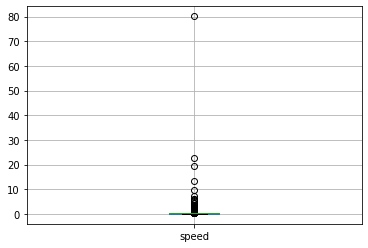

In [ ]:
taxi.boxplot(column = 'speed')

In [ ]:
taxi = taxi[(taxi['total_distance']/taxi['trip_min'])<1]
taxi = taxi[(taxi['total_distance']/taxi['trip_min'])>0.06]

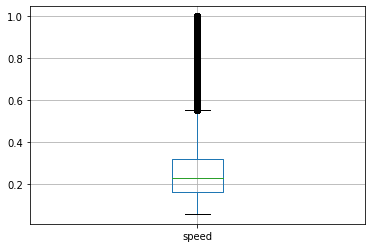

In [ ]:
taxi.boxplot(column = 'speed')

In [ ]:
taxi.drop(["trip_min","speed"],axis=1,inplace=True)

In [ ]:
# taxi=(remove_outliers2(taxi,["total_distance"]))

In [ ]:
# taxi=remove_outliers(taxi)

In [ ]:
taxi.shape

(1364283, 13)

##EDA

In [ ]:
numeric_feature = ['vendor_id', 'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'trip_duration',
       'pickup_month', 'total_distance']
numeric_feature

['vendor_id',
 'passenger_count',
 'pickup_longitude',
 'pickup_latitude',
 'dropoff_longitude',
 'dropoff_latitude',
 'trip_duration',
 'pickup_month',
 'total_distance']

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Target_variable')

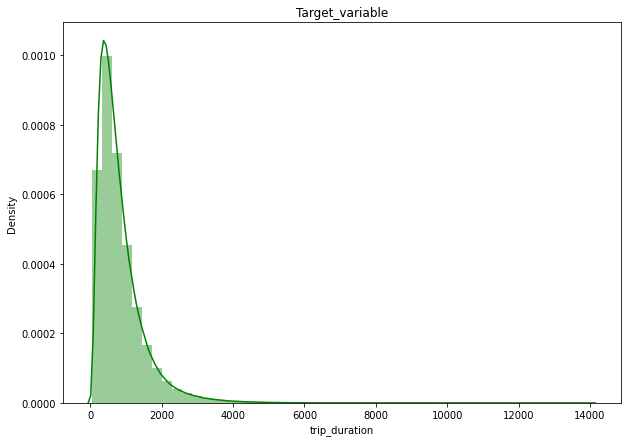

In [ ]:
# Now check the distribution of dependent variable
import seaborn as sns
fig = plt.figure(figsize=(10,7))
sns.distplot(taxi['trip_duration'], color = 'g')
plt.title('Target_variable')

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


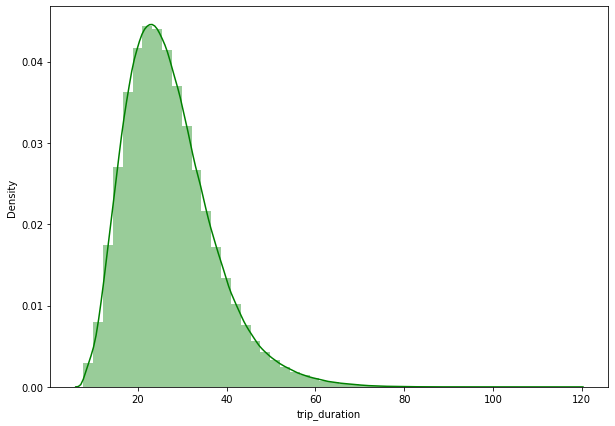

In [ ]:
fig = plt.figure(figsize=(10,7))
sns.distplot(np.sqrt(taxi['trip_duration']), color = 'g')

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


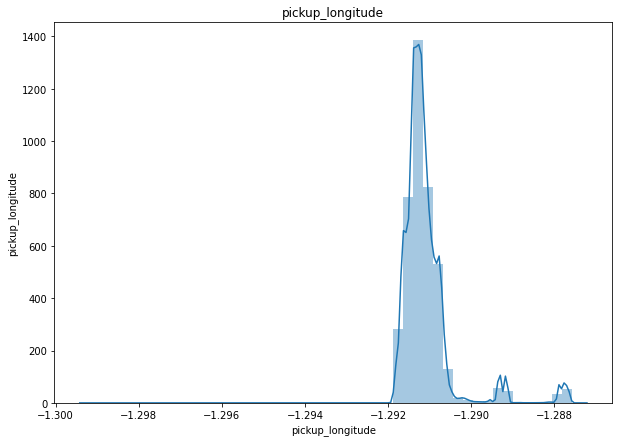

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


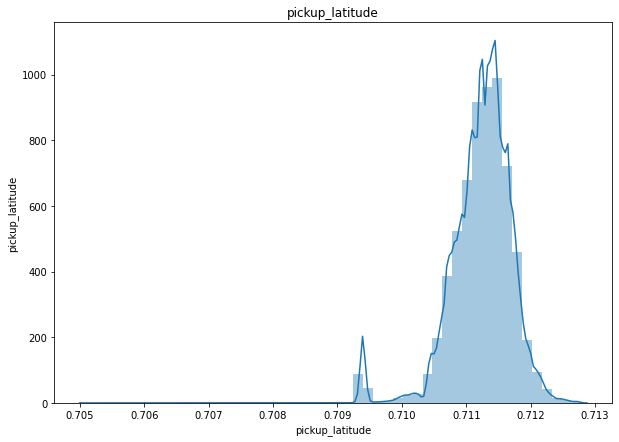

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


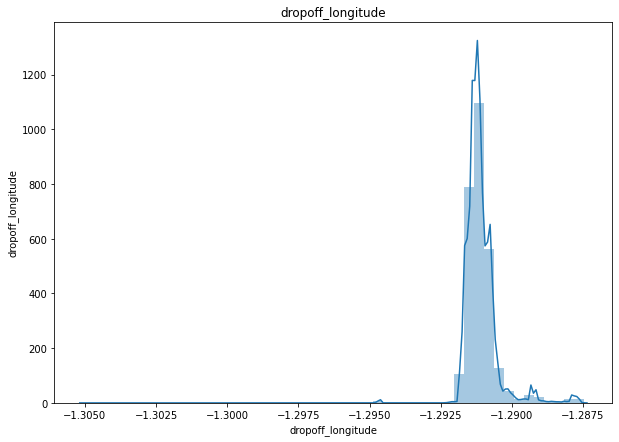

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


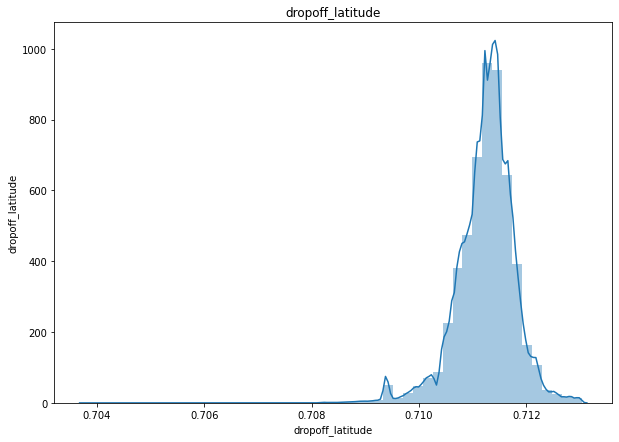

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


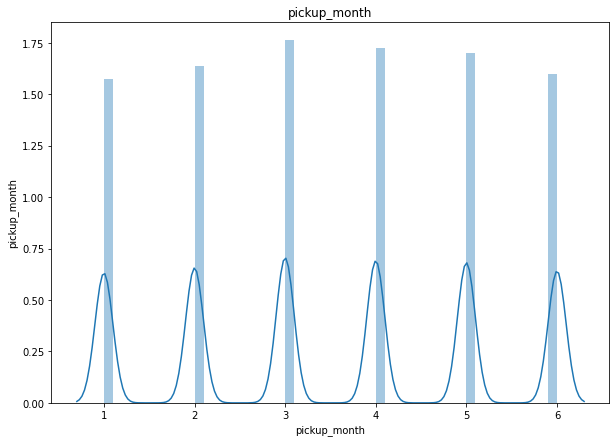

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


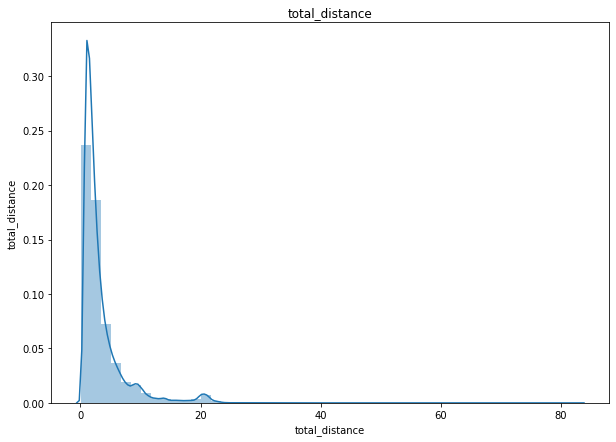

In [ ]:
for col in numeric_feature[1:]:
  if col not in ['passenger_count','trip_duration']:
    fig = plt.figure(figsize=(10,7))
    sns.distplot(taxi[col])
    plt.ylabel(col)
    plt.title(col)
    plt.show()

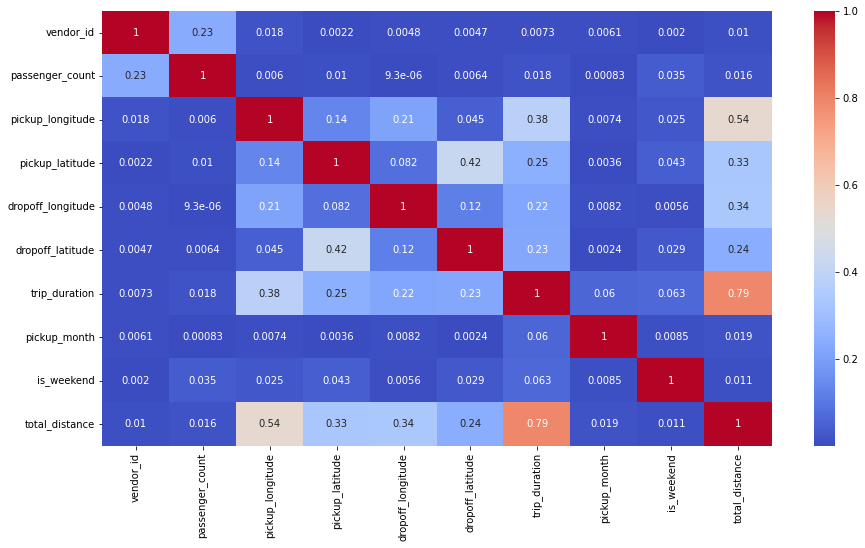

In [ ]:
#let's have a look at correlation of different attributes and remove multicollinearity
plt.figure(figsize=(15,8))
correlation = taxi.corr()
sns.heatmap(abs(correlation), annot=True, cmap='coolwarm')

From here we note that there is a good correlation between trip_durationa and total distance, so we conclude that duration mainly depends on distance and not on the path or the initial and final positions, so we drop the four columns which represents geographic location of final and initial point

In [ ]:
#Now we do some analysis on categorical variable
categorical_feature = list(taxi.describe(include = 'object').columns)
categorical_feature.extend(['is_weekend'])

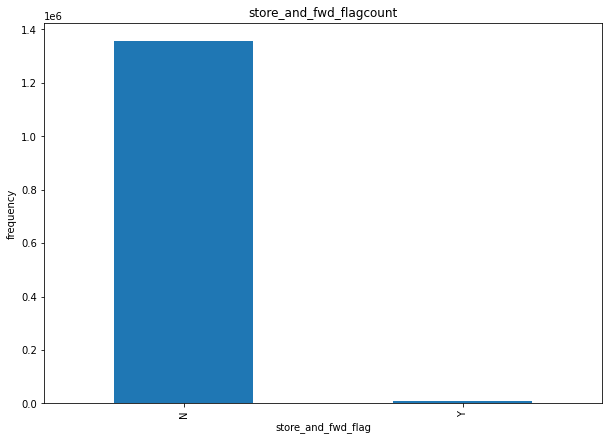

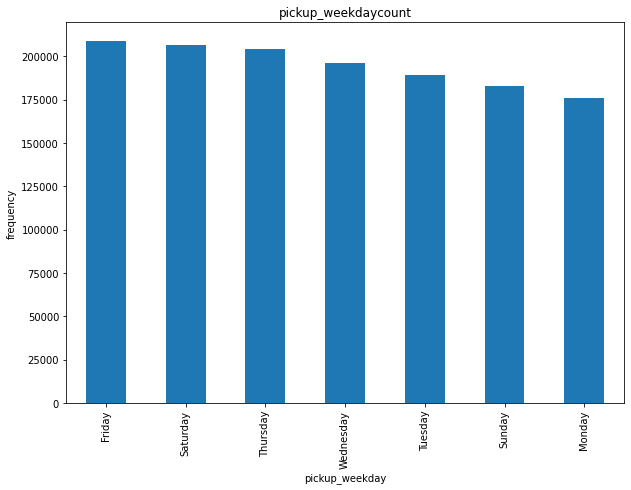

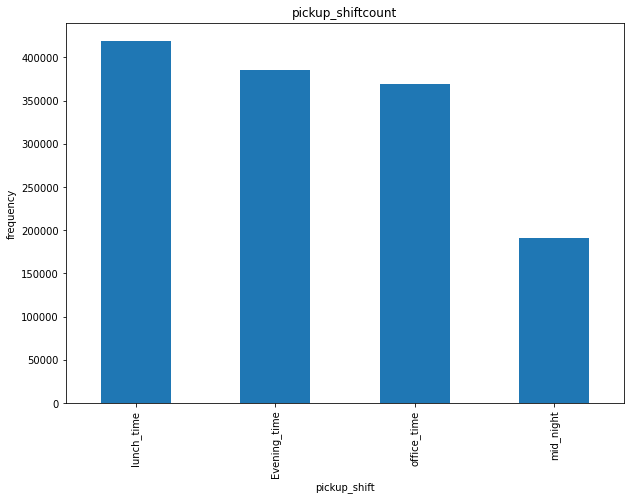

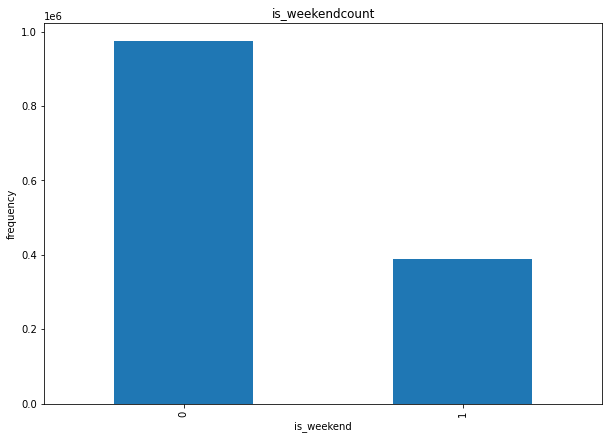

In [ ]:
#to have a look at the distribution of various categorical features
for col in categorical_feature:
  fig = plt.figure(figsize= (10,7))
  ax = fig.gca()
  counts = taxi[col].value_counts()
  counts.plot.bar(ax=ax)
  ax.set_title(col + 'count')
  ax.set_xlabel(col)
  ax.set_ylabel('frequency')

So we will drop the column pickup_weekday and pickup_hours as pickup_weekday and pickup_is_weekend is correlated to each other. Whereas pickup_hours and pickup_shift are correlated.

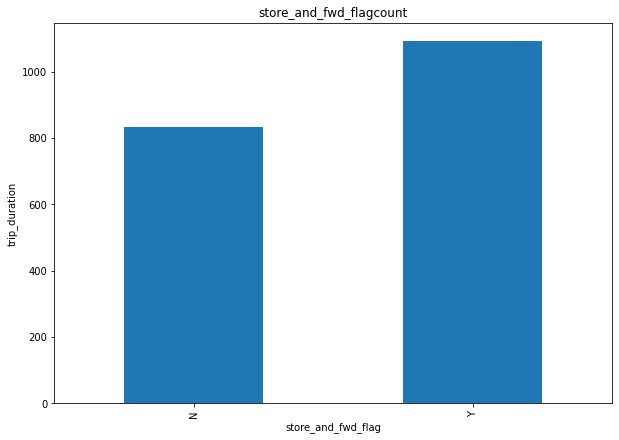

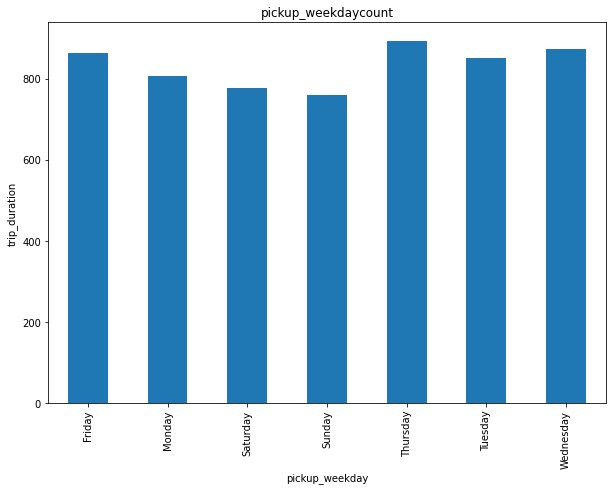

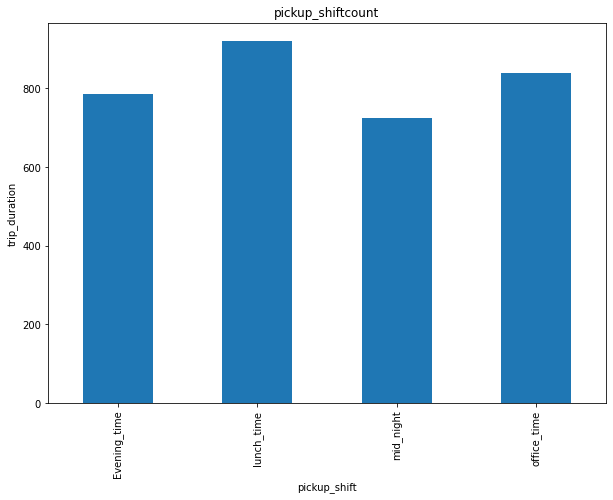

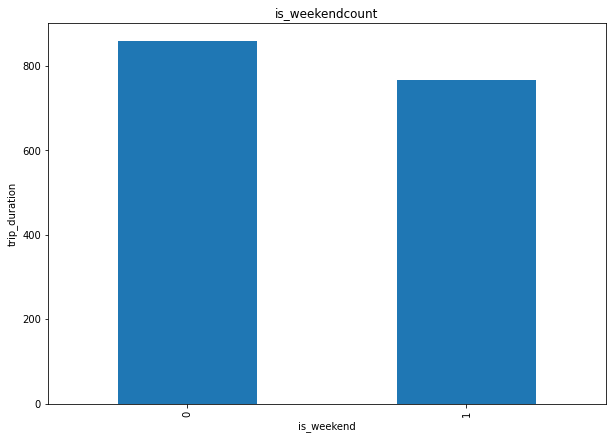

In [ ]:
for col in categorical_feature:
  fig = plt.figure(figsize= (10,7))
  ax = fig.gca()
  Distance_travel = taxi.groupby(col)['trip_duration'].mean()
  Distance_travel.plot.bar(ax=ax)
  ax.set_title(col + 'count')
  ax.set_xlabel(col)
  ax.set_ylabel('trip_duration')

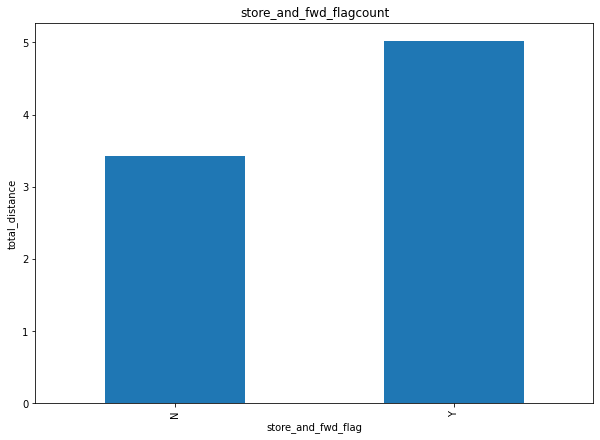

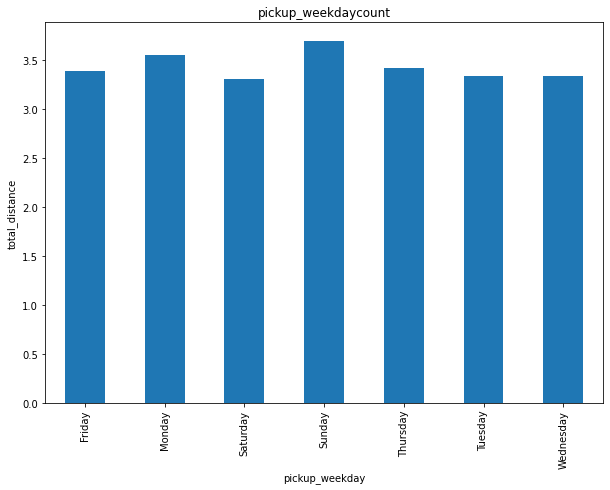

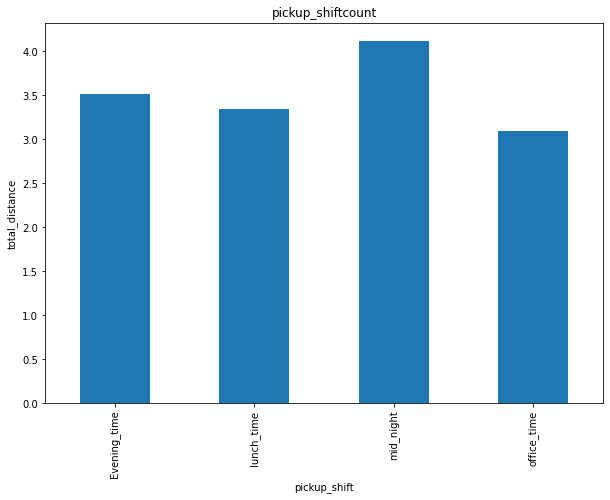

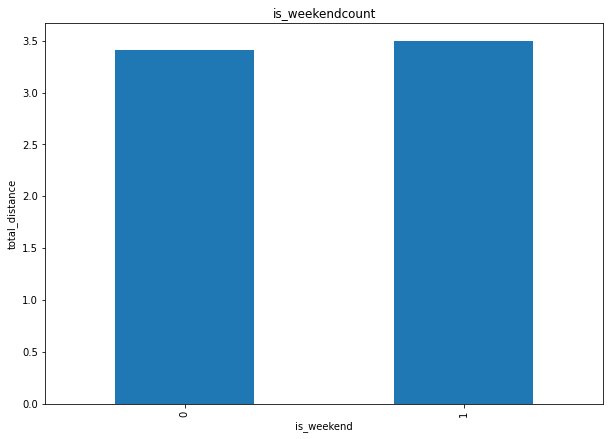

In [ ]:
for col in categorical_feature:
  fig = plt.figure(figsize= (10,7))
  ax = fig.gca()
  Distance_travel = taxi.groupby(col)['total_distance'].mean()
  Distance_travel.plot.bar(ax=ax)
  ax.set_title(col + 'count')
  ax.set_xlabel(col)
  ax.set_ylabel('total_distance')

From pickup_shift it is clearly visible that, at lunch time taxi takes long time to cover short distance, whereas at midnight taxi takes short time to cover long distance. This implies people face lots off traffic during lunch time.

Also in weekend people travel same distance as they travelled in weekday in shorter time.

In [ ]:
taxi.head()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_month,pickup_weekday,is_weekend,pickup_shift,total_distance
0,2,1,-1.291232,0.711535,-1.290926,0.711494,N,455,3,Monday,0,lunch_time,1.500127
1,1,1,-1.291202,0.711022,-1.291535,0.710893,N,663,6,Sunday,1,mid_night,1.807443
2,2,1,-1.291178,0.711465,-1.291637,0.710525,N,2124,1,Tuesday,0,office_time,6.391944
3,2,1,-1.291719,0.710698,-1.291758,0.710466,N,429,4,Wednesday,0,Evening_time,1.487091
4,2,1,-1.291073,0.711976,-1.291071,0.711789,N,435,3,Saturday,1,lunch_time,1.189863


In [ ]:
features=categorical_feature.extend(["vendor_id","pickup_month"])

In [ ]:
categorical_feature

['store_and_fwd_flag',
 'pickup_weekday',
 'pickup_shift',
 'is_weekend',
 'vendor_id',
 'pickup_month']

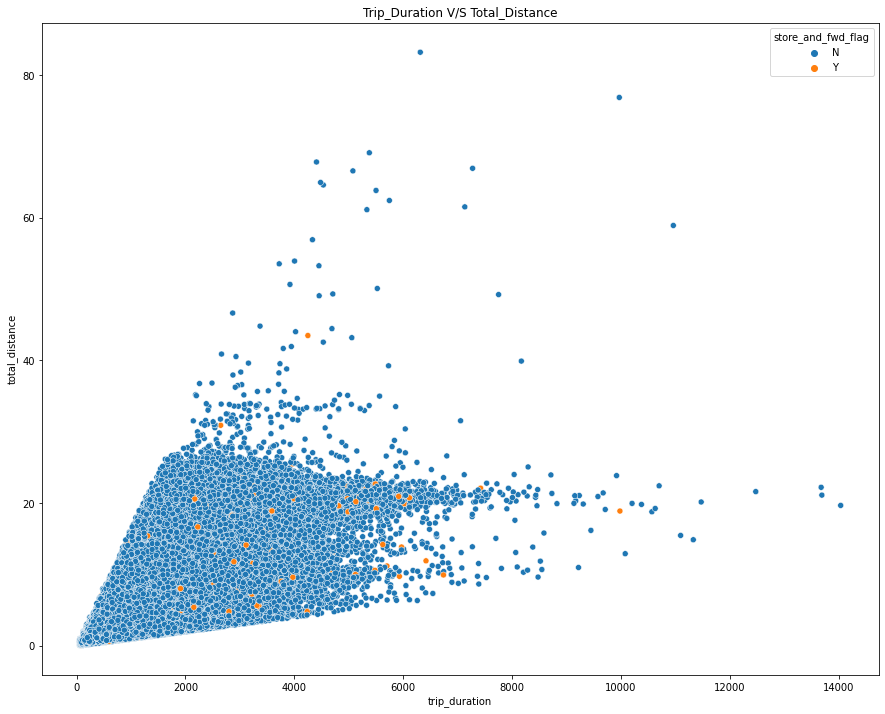

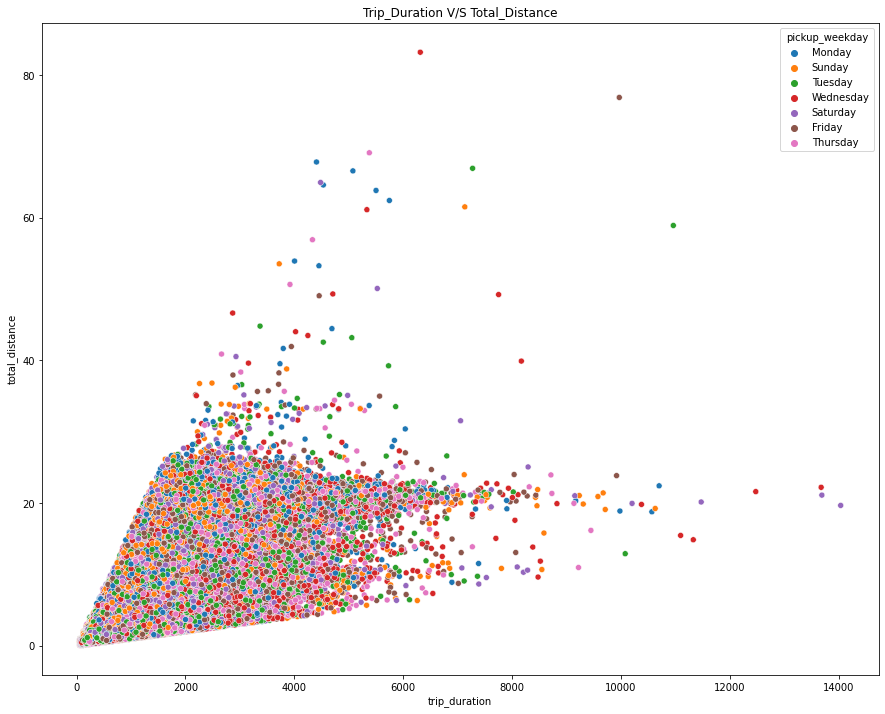

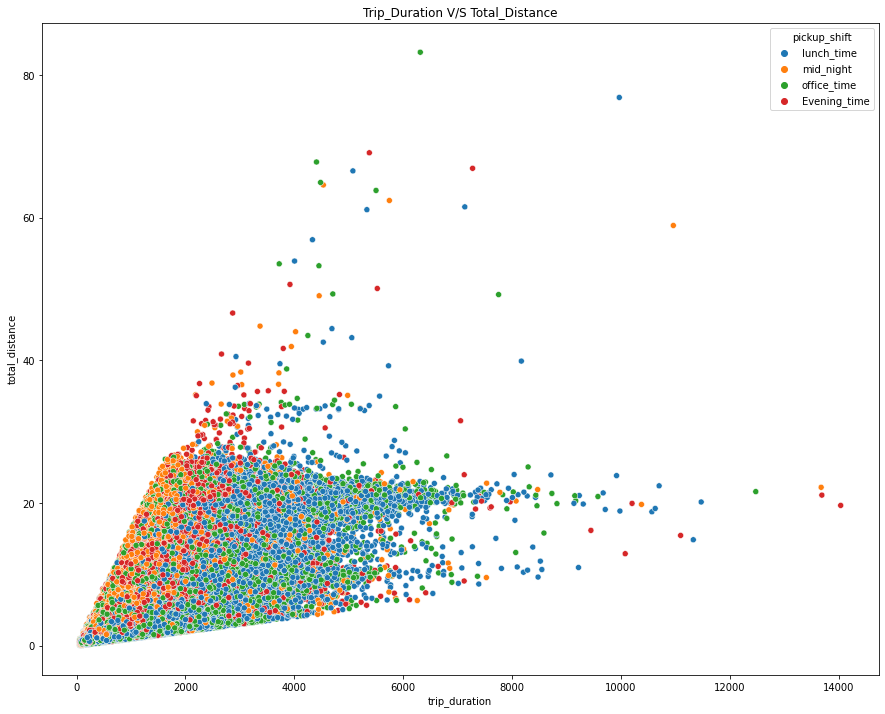

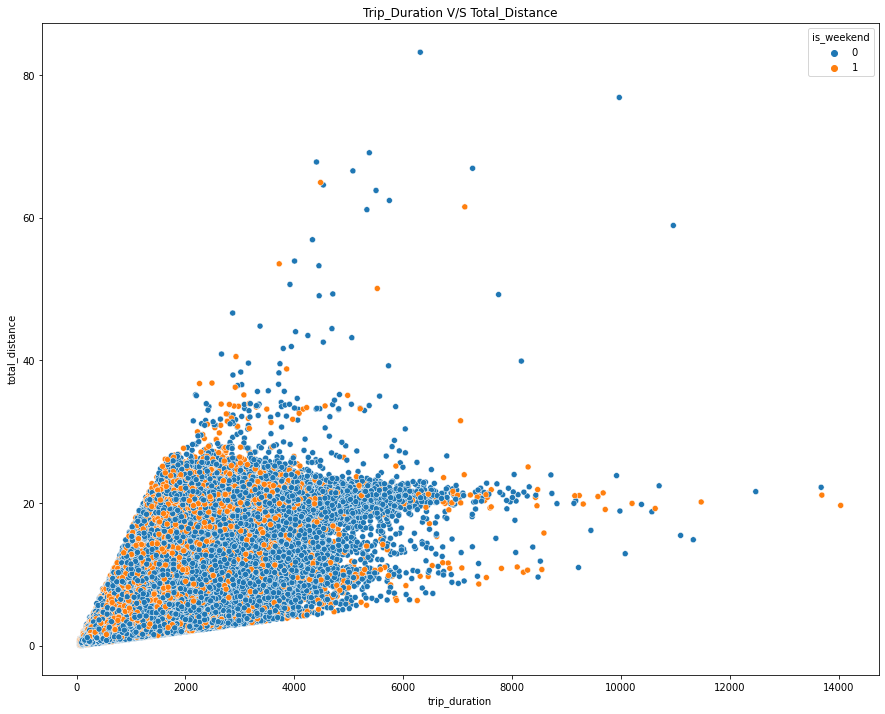

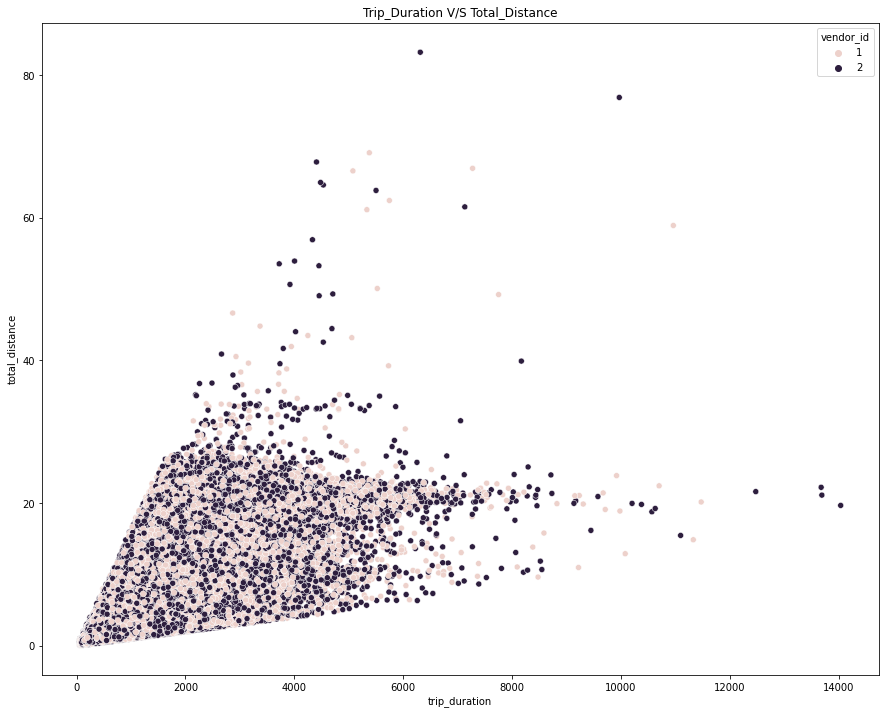

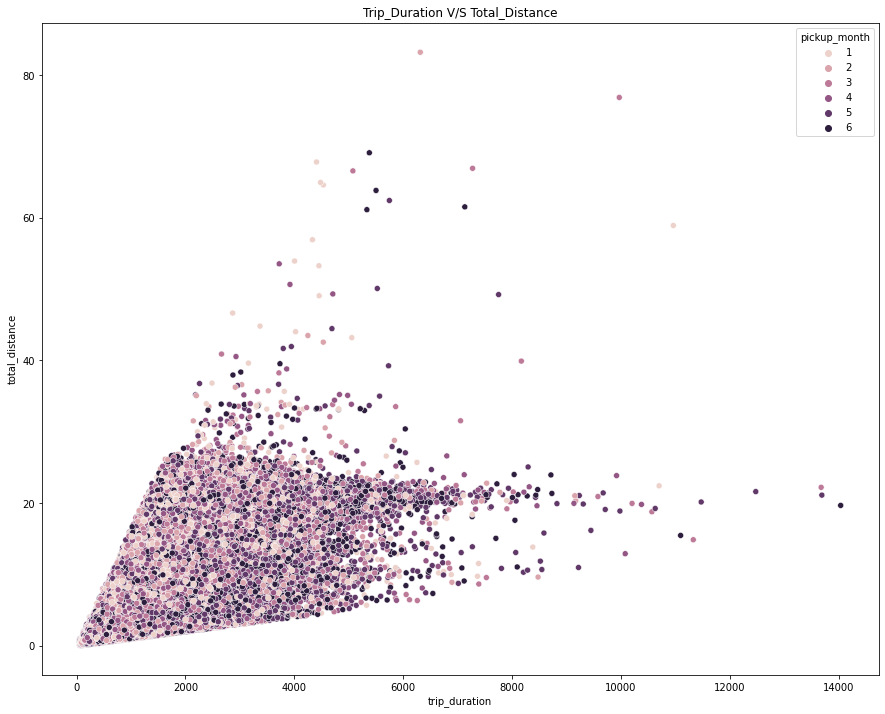

In [ ]:
#but we do not very much bother about their separate distribution what we care about is how these features affect our dependent variable
features=["vendor_id","pickup_month"]+categorical_feature
for col in categorical_feature:
  plt.figure(figsize=(15,12),facecolor='white',edgecolor='orange')
  plt.title("trip_duration v/s total_distance".title())
  sns.scatterplot(x="trip_duration",y="total_distance",data=taxi,hue=col, alpha=1, legend="brief")#,y_bins=[10*i for i in range(0,20)])
  plt.show()

From above we note that:
- vendor_id: For a longer trip or for a longer path vendor_id 2 is preffered
- pickup_month: Data is not properly separated but for a better result we will do some more analysis on this column.
- store_and_fwd_flag: This is a biased column, also there is no particular separation so we will drop it.
- pickup_weekday: there is no particular separation so we will drop it.
- pickup_shift and pickup_isweekend shows some boudaries through which we can separate different colours so these attributes are important

In [ ]:
# taxi.drop(['store_and_fwd_flag', 'pickup_weekday'],axis=1,inplace=True)

Conclusion:
First two features do not bother the pick_up duration much, as we note that all the colurs are mixed , and is particular boundary which tends to separate them so we drop the first two features

In [ ]:
categorical_feature=taxi.describe(include="object")

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


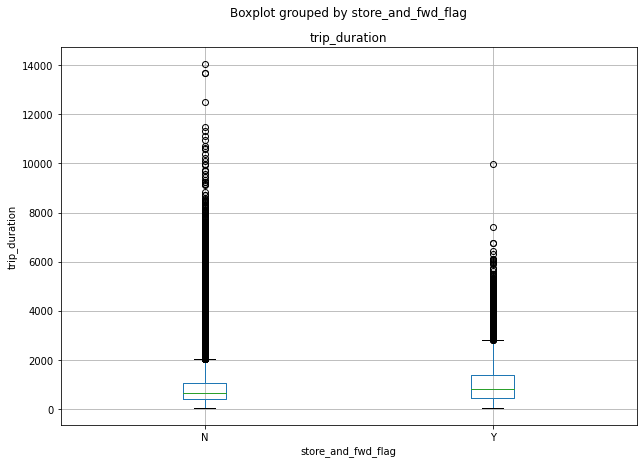

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


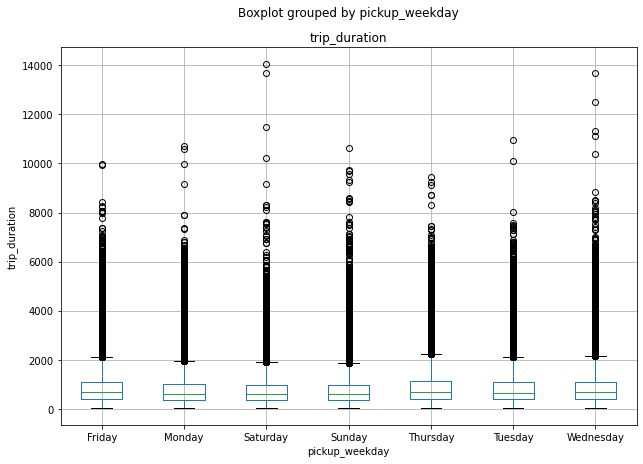

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


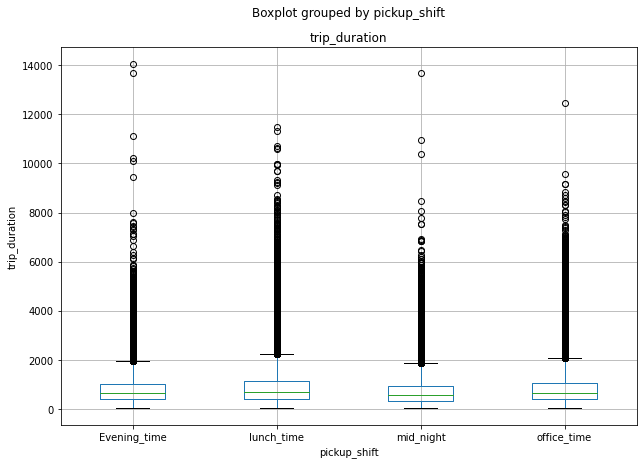

In [ ]:
for col in categorical_feature:
  fig = plt.figure(figsize=(10,7))
  ax = fig.gca()
  taxi.boxplot(column = 'trip_duration',by = col, ax=ax)
  ax.set_xlabel(col)
  ax.set_ylabel('trip_duration')
  plt.show()


In [ ]:
#some analysis on pickup month

taxi["pickup_month"].value_counts()
#there are total six pickup months and other six month  data is not included so what if we want to get a duration for any 
#of the next six month, so we drop this attribute also
taxi.drop(["pickup_month"],axis=1,inplace=True)

In [ ]:
taxi["pickup_shift"].unique()

array(['lunch_time', 'mid_night', 'office_time', 'Evening_time'],
      dtype=object)

In [ ]:
##LabelEncoder convert the categorical attribute, pickup_shift into ordinal variables.
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
taxi['pickup_shift'] = encoder.fit_transform(taxi['pickup_shift'])

In [ ]:
for i in range(len(encoder.classes_)):
  print(f'{i}:{encoder.classes_[i]}')

0:Evening_time
1:lunch_time
2:mid_night
3:office_time


In [ ]:
pd.crosstab(taxi["is_weekend"],taxi["pickup_shift"])

pickup_shift,0,1,2,3
is_weekend,,,,
0,288177,297067,105261,284242
1,96888,122139,85234,85275


Evening time and office time the taxis are comparitively more busy if the day is not a weekend.

In [ ]:
#columns left with us
taxi.columns

Index(['vendor_id', 'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration', 'pickup_weekday', 'is_weekend', 'pickup_shift',
       'total_distance'],
      dtype='object')

In [ ]:
(taxi.describe()).columns #here we note that all the columns have numeric data type so data is ready for prediction

Index(['vendor_id', 'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'trip_duration', 'is_weekend',
       'pickup_shift', 'total_distance'],
      dtype='object')

In [ ]:
taxi['store_and_fwd_flag'] = taxi['store_and_fwd_flag'].replace({'N':0,'Y':1})

##Base_line_model


In [ ]:
numeric_feature1 = taxi.describe().columns
numeric_feature1

Index(['vendor_id', 'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration', 'is_weekend', 'pickup_shift', 'total_distance'],
      dtype='object')

In [ ]:
#remove multicollinearity
from statsmodels.stats.outliers_influence import variance_inflation_factor
def calc_vif(x):
  vif = pd.DataFrame()
  vif['columns'] = x.columns
  vif['vif_values'] = [variance_inflation_factor(x.values,i) for i in range(x.shape[1])]

  return vif

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
calc_vif(taxi[[col for col in numeric_feature1 if col not in ['trip_duration','pickup_longitude', 'pickup_latitude','dropoff_longitude', 'dropoff_latitude']]])


,columns,vif_values
0,vendor_id,4.630525
1,passenger_count,3.106196
2,store_and_fwd_flag,1.006684
3,is_weekend,1.366205
4,pickup_shift,2.170982
5,total_distance,1.712817


VIF measure the multicollinearity between the independent variable. We will drop the multicolinear feature only for linear regression model. Other model like Decesion tree,
GBM, XGB are not affected by multicollinearity

In [ ]:
corr_class=abs((taxi.corr())["trip_duration"]).sort_values(ascending=False)
independent_var=(corr_class.index)
independent_var

Index(['trip_duration', 'total_distance', 'pickup_longitude',
       'pickup_latitude', 'dropoff_latitude', 'dropoff_longitude',
       'is_weekend', 'store_and_fwd_flag', 'passenger_count', 'vendor_id',
       'pickup_shift'],
      dtype='object')

In [ ]:
linear_set = ['total_distance', 'pickup_longitude','is_weekend',  'passenger_count', 'vendor_id','pickup_shift']


In [ ]:
#building model

 
#independent_var =list((abs((taxi.corr())["trip_duration"]).sort_values(ascending=False)).index)[1:]
dependent_var=["trip_duration"]
# independent_var
xl=taxi[linear_set]
yl=taxi["trip_duration"]
#arranged independent var in proper order

#just to try
#x=x.iloc[:50000]
#y=y.iloc[:50000]

In [ ]:
#train-test split

from sklearn.model_selection import train_test_split
xl_train,xl_test,yl_train,yl_test= train_test_split(xl, yl, test_size=0.30, random_state=324)



In [ ]:
xl_train.shape

(954998, 6)

In [ ]:
xl_test.shape

(409285, 6)

In [ ]:
#Does it refer to whether the roots are real or not real, equal or unequal?

##Linear Regression
we have used this model because we found a good correalation of some independent attribute with our dependent attribute but this model is not very efficient as R2 score is very less and rmse is high.

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

In [ ]:
linear_model=LinearRegression()
linear_model.fit(xl_train,yl_train)


LinearRegression()

In [ ]:
y_train_predicted=linear_model.predict(xl_train)
y_test_predicted=linear_model.predict(xl_test)




In [ ]:
math.sqrt(mean_squared_error(yl_train,y_train_predicted))

392.6091293317538

In [ ]:
r2_score(yl_train, y_train_predicted)

0.6336056692179107

In [ ]:
r2_score(yl_test, y_test_predicted)

0.6328392453458908

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0.98, 'Residual Analysis')

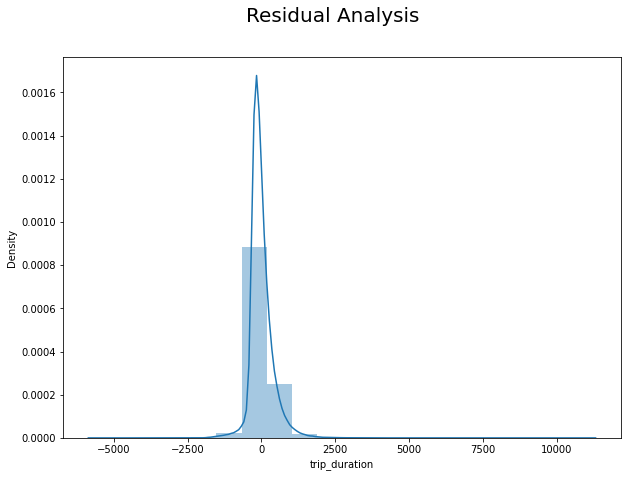

In [ ]:
#Residual_analysis
fig = plt.figure(figsize = (10,7))
sns.distplot((yl_test-y_test_predicted),bins=20)

#Plot Label
fig.suptitle('Residual Analysis', fontsize = 20)

##Ridge
As ridge regression is used when data is highly correlated so we use all the columns of data

In [ ]:
corr_class=abs((taxi.corr())["trip_duration"]).sort_values(ascending=False)
independent_var=(corr_class.index)
independent_var=independent_var[1:]

In [ ]:
#building model

 
#independent_var =list((abs((taxi.corr())["trip_duration"]).sort_values(ascending=False)).index)[1:]
dependent_var=["trip_duration"]
# independent_var
xl=taxi[independent_var]
yl=taxi["trip_duration"]
#arranged independent var in proper order

#just to try
#x=x.iloc[:50000]
#y=y.iloc[:50000]

In [ ]:
#train-test split

from sklearn.model_selection import train_test_split
xl_train,xl_test,yl_train,yl_test= train_test_split(xl, yl, test_size=0.30, random_state=324)



In [ ]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
ridge=Ridge()
params={"alpha":[1e-15,1e-10,1e-8,1e-3,1e-2,1,2,3,4,5,10,20,30]}
ridge_regressor=GridSearchCV(ridge,params,scoring="r2",cv=5)
ridge_regressor.fit(xl_train,yl_train)
print(ridge_regressor.best_params_)   #which lemda value is most suitable.
print(ridge_regressor.best_score_)     
#is linear regression mean  mse is -37.something which is lesser than -31._____  so ridge regression is not good in this case.

{'alpha': 1e-08}
0.637298730627091


In [ ]:
y_train_predicted=ridge_regressor.predict(xl_train)
y_test_predicted=ridge_regressor.predict(xl_test)




In [ ]:
math.sqrt(mean_squared_error(yl_train,y_train_predicted))

390.61020826530563

In [ ]:
r2_score(yl_train, y_train_predicted)

0.6373270747918178

In [ ]:
r2_score(yl_test, y_test_predicted)

0.6369063323395263

##Lasso

In [ ]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
lasso=Lasso()
params={"alpha":[1e-15,1e-10,1e-8,1e-3,1e-2,1,2,3,4,5,10,20,30,40,45,50,55,70,90,100]}
lasso_regressor=GridSearchCV(lasso,params,scoring="neg_mean_squared_error",cv=5)
lasso_regressor.fit(xl_train,yl_train)
print(lasso_regressor.best_params_)
print(lasso_regressor.best_score_)    

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.814e+10, tolerance: 3.214e+07
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.699e+10, tolerance: 3.225e+07
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisa

{'alpha': 1e-08}
-152584.37009907307


In [ ]:
y_train_predicted=lasso_regressor.predict(xl_train)
y_test_predicted=lasso_regressor.predict(xl_test)


In [ ]:
math.sqrt(mean_squared_error(yl_train,y_train_predicted))

390.6102082653065

In [ ]:
r2_test=r2_score(yl_train, y_train_predicted)

In [ ]:
r2_score(yl_test, y_test_predicted)

0.6369063324473132

##Observation 1

In [ ]:
def model_estimator(models,x_train,x_test,y_train,y_test,best_estimator = True):
  cols = ['Train_MSE','Test_MSE','Train_RMSE','Test_RMSE','Train_r2_score','Test_r2_score','Train_Adjusted_r2_score','Test_Adjusted_r2_score']
  model_df = pd.DataFrame()
  model_list = list(models.keys())
  
  i = 0
  for model in model_list:
    models[model].fit(x_train,y_train)
    y_pred_train = models[model].predict(x_train)
    y_pred_test = models[model].predict(x_test)

    model_df.loc[i,'Model_Name'] = model_list[i]
    model_df.loc[i,'Train_MSE'] = mean_squared_error((y_train), (y_pred_train)).round(2)
    model_df.loc[i,'Test_MSE'] = mean_squared_error((y_test), (y_pred_test)).round(2)
    model_df.loc[i,'Train_RMSE'] = np.sqrt(mean_squared_error((y_train), (y_pred_train))).round(2)
    model_df.loc[i,'Test_RMSE'] = np.sqrt(mean_squared_error((y_test), (y_pred_test))).round(2)
    model_df.loc[i,'Train_r2_score'] = r2_score((y_train), (y_pred_train)).round(2)
    model_df.loc[i,'Test_r2_score'] = r2_score((y_test), (y_pred_test)).round(2)
    model_df.loc[i,'Train_Adjusted_r2_score'] = (1-(1-r2_score((y_train), (y_pred_train)))*((x_train.shape[0]-1)/(x_train.shape[0]-x_train.shape[1]-1))).round(2)
    model_df.loc[i,'Test_Adjusted_r2_score'] = (1-(1-r2_score((y_test), (y_pred_test)))*((x_test.shape[0]-1)/(x_test.shape[0]-x_test.shape[1]-1))).round(2)


    #Residual_analysis
    fig = plt.figure(figsize = (10,7))
    sns.distplot((y_test-y_pred_test),bins=20)

    #Plot Label
    fig.suptitle(model_list[i]+' '+'Residual Analysis', fontsize = 15)


    if best_estimator:
      cols.append(['best_estimator'])
      model_df.loc[i,'best_estimator'] = models[model].best_estimator_


    
    i = i+1
  
  return  model_df



In [ ]:
models = {'linear_regression':linear_model,'lasso_regressor':lasso_regressor,'ridge_regressor':ridge_regressor}

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.814e+10, tolerance: 3.214e+07
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.6

,Model_Name,Train_MSE,Test_MSE,Train_RMSE,Test_RMSE,Train_r2_score,Test_r2_score,Train_Adjusted_r2_score,Test_Adjusted_r2_score
0,linear_regression,152576.33,151882.3,390.61,389.72,0.64,0.64,0.64,0.64
1,lasso_regressor,152576.33,151882.3,390.61,389.72,0.64,0.64,0.64,0.64
2,ridge_regressor,152576.33,151882.3,390.61,389.72,0.64,0.64,0.64,0.64


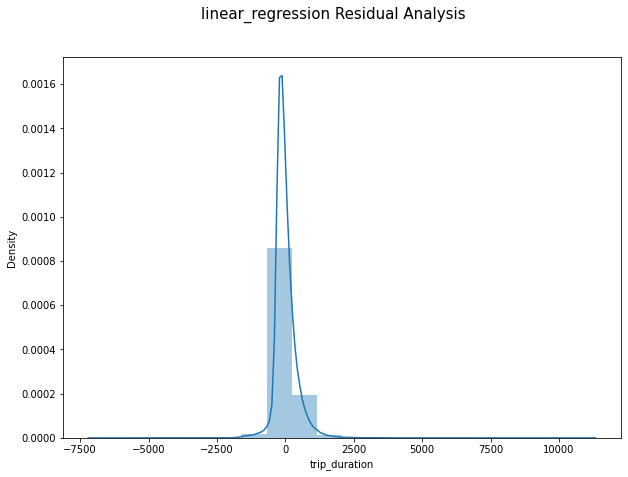

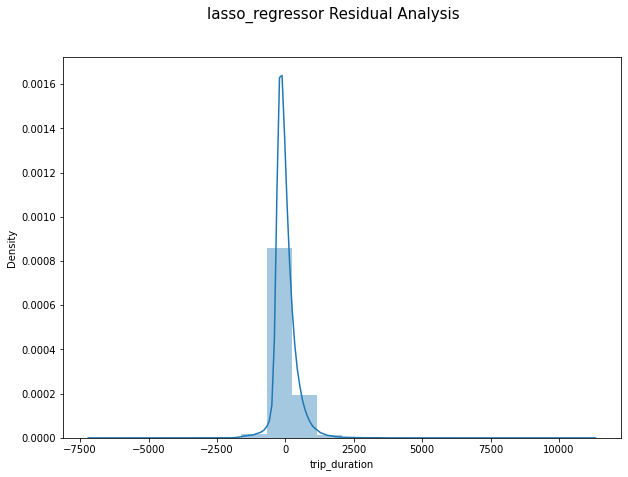

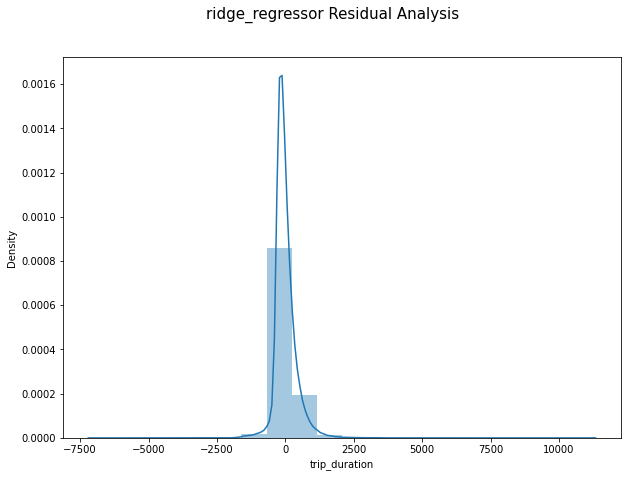

In [ ]:
model_estimator(models,xl_train,xl_test,yl_train,yl_test,best_estimator = False)

##Decesion Tree

In [ ]:
independent_var[1:]

Index(['pickup_longitude', 'pickup_latitude', 'dropoff_latitude',
       'dropoff_longitude', 'is_weekend', 'store_and_fwd_flag',
       'passenger_count', 'vendor_id', 'pickup_shift'],
      dtype='object')

In [ ]:
independent_var =independent_var
dependent_var=["trip_duration"]
x=taxi[independent_var]
y=taxi["trip_duration"]

In [ ]:
x_train,x_test,y_train,y_test= train_test_split(x, y, test_size=0.30, random_state=324)

In [ ]:
x_train.shape

(954998, 10)

In [ ]:
#base_line_model
from sklearn.tree import DecisionTreeRegressor 
  
# create a regressor object
decision_tree = DecisionTreeRegressor(random_state = 0) 


##GradientBoosting

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
GBM_model=GradientBoostingRegressor()
GBM_model.fit(x_train,y_train)

GradientBoostingRegressor()

##XGBRegressor

In [ ]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
XGB_model = XGBRegressor()
XGB_model.fit(x_train,y_train)

[08:20:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor()

In [ ]:
models = {'Decision_tree':decision_tree,'GBM_model':GBM_model,'XGB_model':XGB_model}

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


[08:25:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


,Model_Name,Train_MSE,Test_MSE,Train_RMSE,Test_RMSE,Train_r2_score,Test_r2_score,Train_Adjusted_r2_score,Test_Adjusted_r2_score
0,Decision_tree,0.00,171586.81,0.00,414.23,1.00,0.59,1.00,0.59
1,GBM_model,105790.84,106068.94,325.26,325.68,0.75,0.75,0.75,0.75
2,XGB_model,104994.05,105347.27,324.03,324.57,0.75,0.75,0.75,0.75


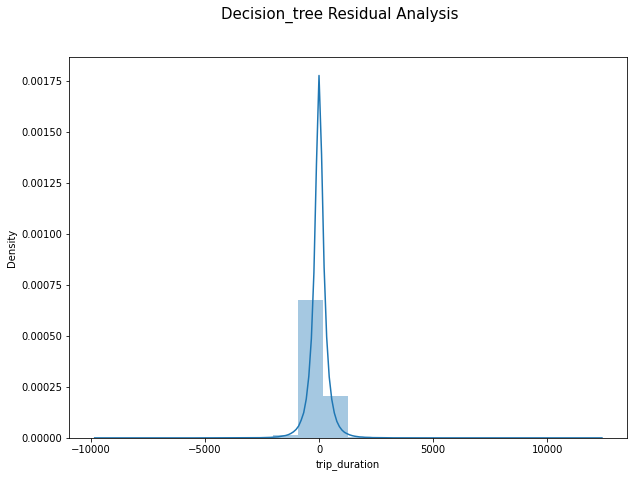

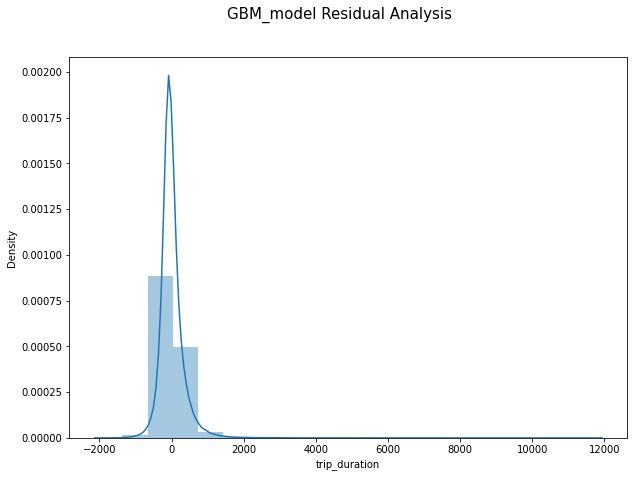

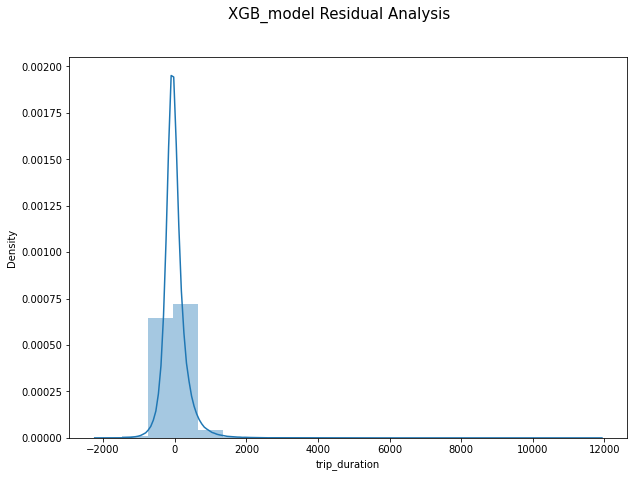

In [ ]:
model_estimator(models,x_train,x_test,y_train,y_test,best_estimator = False)

So decesion tree is overfitted, we tuned the hyperparamter to fix this problem

##Model Validation and Hyperparameter Tuning

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
model = DecisionTreeRegressor()
params = {'max_depth':[15],'min_samples_split':[600],'min_impurity_decrease':[0.1]}
cv = KFold(n_splits = 3,shuffle=True,random_state = 0)
decision_tree_tuned = GridSearchCV(model,param_grid = params,scoring = 'r2', cv = cv)
decision_tree_tuned.fit(x_train,y_train)

GridSearchCV(cv=KFold(n_splits=3, random_state=0, shuffle=True),
             estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': [15], 'min_impurity_decrease': [0.1],
                         'min_samples_split': [600]},
             scoring='r2')

In [ ]:
print("Best: %f using %s" % (decision_tree_tuned.best_score_, decision_tree_tuned.best_params_))

Best: 0.760647 using {'max_depth': 15, 'min_impurity_decrease': 0.1, 'min_samples_split': 600}


In [ ]:
y_pred_tuned_dt_tr = decision_tree_tuned.predict(x_train)
y_pred_tuned_dt_te = decision_tree_tuned.predict(x_test)

In [ ]:
r2 = r2_score((y_test), (y_pred_tuned_dt_te))
r2

0.7645961754934238

In [ ]:
r2 = r2_score((y_train), (y_pred_tuned_dt_tr))
r2

0.7761131037247793

In [ ]:
MSE  = mean_squared_error((y_test), (y_pred_tuned_dt_te))
print("MSE :" , MSE)

RMSE = np.sqrt(MSE)
print("RMSE :" ,RMSE)

MSE : 98469.56301873854
RMSE : 313.7986026398756


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0.98, 'Residual Analysis')

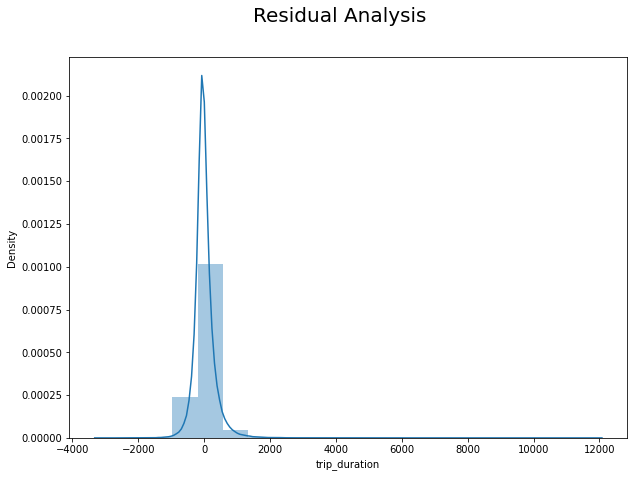

In [ ]:
#Residual_analysis
fig = plt.figure(figsize = (10,7))
sns.distplot((y_test-y_pred_tuned_dt_te),bins=20)

#Plot Label
fig.suptitle('Residual Analysis', fontsize = 20)

##Gradient Boosting:

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
grid_values = {'n_estimators':[90], 'max_depth':[9]}
tune_model_gbm= RandomizedSearchCV(GBM_model, param_distributions = grid_values, scoring = 'r2', cv=3)
tune_model_gbm.fit(x_train,y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:296: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  UserWarning,


RandomizedSearchCV(cv=3, estimator=GradientBoostingRegressor(),
                   param_distributions={'max_depth': [9], 'n_estimators': [90]},
                   scoring='r2')

In [ ]:
print("Best: %f using %s" % (tune_model_gbm.best_score_, tune_model_gbm.best_params_))

Best: 0.794443 using {'n_estimators': 90, 'max_depth': 9}


In [ ]:
y_train_predicted=tune_model_gbm.predict(x_train)
y_test_predicted=tune_model_gbm.predict(x_test)




In [ ]:
r2_score(y_train, y_train_predicted)

0.8168274100147422

In [ ]:
r2_score(y_test, y_test_predicted)

0.7943399579090467

In [ ]:
tune_model_gbm.best_estimator_

GradientBoostingRegressor(max_depth=9, n_estimators=90)

**XGBRegressor**

In [ ]:
learning_rate = [0.5]
subsample = [0.9]
max_depth = [7]
grid = dict(learning_rate=learning_rate, subsample=subsample, max_depth=max_depth)
xgb_tuned = GridSearchCV(XGB_model,param_grid = grid,scoring = 'r2', cv = 3)
xgb_tuned.fit(x_train,y_train)

[08:58:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:59:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:01:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:02:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


GridSearchCV(cv=3, estimator=XGBRegressor(),
             param_grid={'learning_rate': [0.5], 'max_depth': [7],
                         'subsample': [0.9]},
             scoring='r2')

In [ ]:
print("Best: %f using %s" % (xgb_tuned.best_score_, xgb_tuned.best_params_))

Best: 0.787457 using {'learning_rate': 0.5, 'max_depth': 7, 'subsample': 0.9}


In [ ]:
y_train_predicted=xgb_tuned.predict(x_train)
y_test_predicted=xgb_tuned.predict(x_test)




In [ ]:
math.sqrt(mean_squared_error(y_train,y_train_predicted))

275.8155709397545

In [ ]:
test_rmse=math.sqrt(mean_squared_error(y_test,y_test_predicted))

In [ ]:
r2_train=r2_score(y_train, y_train_predicted)
r2_train

0.8191720671292951

In [ ]:
r2_test=r2_score(y_test, y_test_predicted)
r2_test

0.7893041697643166

In [ ]:
v1= (1-r2_test)
v2= ((x_train.shape[0])-1) / ((x_train.shape[0])-(x_train.shape[1])-1)
adj_rsquared = (1 - (v1 * v2))
adj_rsquared

0.7893019634952236

In [ ]:
validate_models = {'Decesion_tree': decision_tree_tuned, 'XGBRegressor':xgb_tuned,'GBMRegressor':tune_model_gbm}

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


[09:06:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:07:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:09:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:10:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:296: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


,Model_Name,Train_MSE,Test_MSE,Train_RMSE,Test_RMSE,Train_r2_score,Test_r2_score,Train_Adjusted_r2_score,Test_Adjusted_r2_score,best_estimator
0,Decesion_tree,94189.12,98469.56,306.90,313.80,0.78,0.76,0.78,0.76,"DecisionTreeRegressor(max_depth=15, min_impuri..."
1,XGBRegressor,76074.23,88134.19,275.82,296.87,0.82,0.79,0.82,0.79,"XGBRegressor(learning_rate=0.5, max_depth=7, s..."
2,GBMRegressor,77060.63,86004.73,277.60,293.27,0.82,0.79,0.82,0.79,[DecisionTreeRegressor(criterion='friedman_mse...


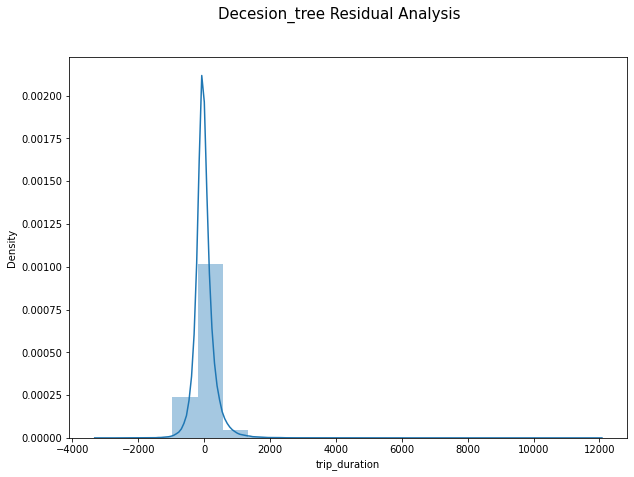

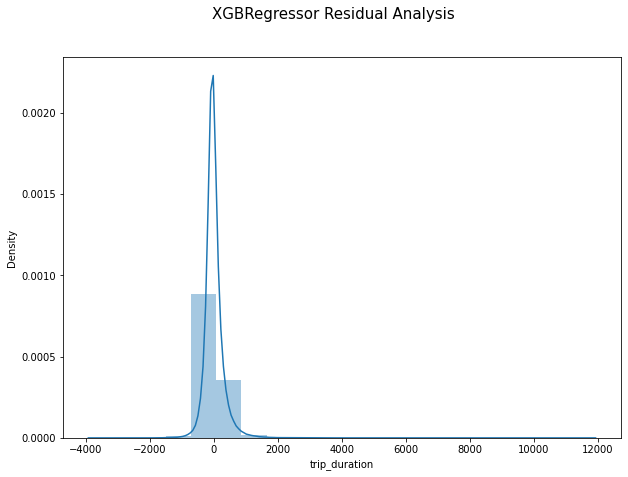

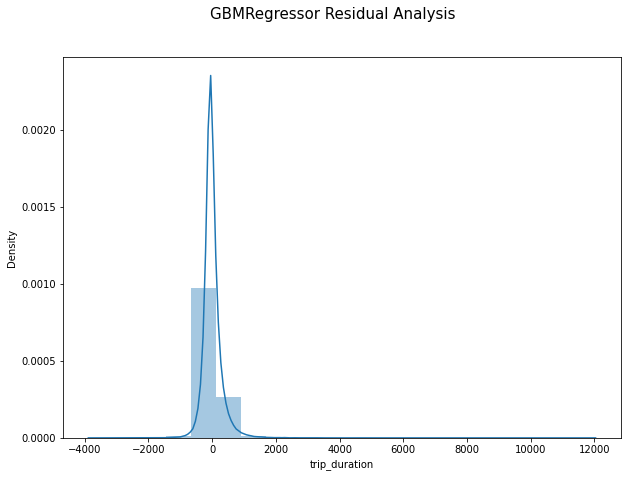

In [ ]:
model_estimator(validate_models,x_train,x_test,y_train,y_test,best_estimator = True)

**Conclusion**
That's it! We reached the end of our 
analysis and finally we have built a 
model for predicting our dependent 
variable. 
Starting with loading the data we first 
performed data cleaning in which we 
remove null values, duplicates and 
outliers from the data and did feature 
engineering and added some very 
useful columns like weekdays, 
is_weekend, day shift, total distance, 
and some other and then we found an 
attribute which have a high correlation 
with dependent column. Then we 
performed EDA and did different 
visualizations using graphical plots and 
as a result of our analysis we draw 
some useful conclusions, which may 
prove beneficial for taxi companies 
and for the passengers as well. Also 
that analysis helps us in building a 
better model with better features. And 
the model will help in predicting 
trip_duration.
